# Neural Networks

## My first neural network: StupidNet™

In [1]:
import torch
from torch import nn
import os

def set_manual_seed(seed=114514):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

### Loading and transforming the dataset

#### Question 1 & 2

<class 'torch.Tensor'>
torch.Size([784]) 0


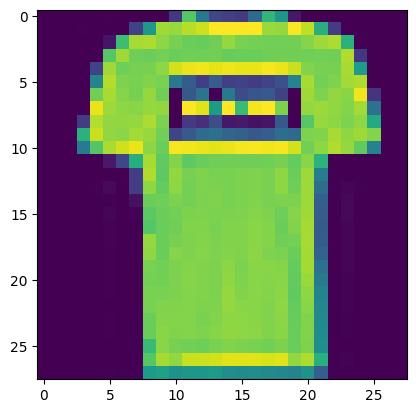

In [2]:
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))  # 将张量展平为一维
])

training_data = datasets.FashionMNIST("../", train=True, transform=transform)
test_data = datasets.FashionMNIST("../", download=True, train=False, transform=transform)

print(type(training_data[1][0]))
print(training_data[1][0].shape, training_data[1][1])
plt.imshow(training_data[1][0].reshape(28,28))

#### Question 3, 4 & 5

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from tqdm import tqdm

def trainer(dataset, model, loss_fn, epoch=10, batch_size=64, rate=1e-4, save_per_epoch=-1, ):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Useless for a single-layer network but we will keep it in order not to lose the generality
    model.train()
    
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = Adam(model.parameters(), lr=rate)
    
    for epoch_idx in range(epoch):
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch_idx+1}/{epoch}", ncols=100)
        
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item())

In [4]:
model_TD1 = nn.Linear(in_features=training_data[0][0].shape[0], out_features=1)

#### Question 6

In [ ]:
def MSE():
    # patch outputs shape and target dtype
    loss_fn = nn.MSELoss()
    return lambda outputs, labels: loss_fn(outputs.squeeze(1), labels.float())

set_manual_seed()    
nn.init.normal_(model_TD1.weight, mean=0.0, std=0.01)
nn.init.zeros_(model_TD1.bias)

trainer(training_data, model_TD1, MSE(), batch_size=5, epoch=30)

os.makedirs('work_dir', exist_ok=True)
torch.save(model_TD1.state_dict(), './work_dir/model_TD1.pt')

In [ ]:
def success_rate(model_TD1, test_data):
    correct = 0
    total = 0
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    model_TD1.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(model_TD1.weight.device), labels.to(model_TD1.weight.device).to(torch.int32)
            outputs = model_TD1(images)
            pred = torch.round(outputs, decimals=0).squeeze(1).to(torch.int32)
            total += labels.shape[0]
            correct += (pred == labels).sum().item()
    return correct/total

print(f"Success Rate of model_TD1: {success_rate(model_TD1, test_data)}")

### Improving StupidNet™: our second neural network

#### Question 7

In [ ]:
model = nn.Sequential(
    nn.Linear(in_features=training_data[0][0].shape[0], out_features=10),
    nn.LogSoftmax(dim=1)
)

# dummy_input = torch.randn(size=(13,784))
# probs_ = torch.exp(model_10(dummy_input))
# assert torch.allclose(
#         torch.sum(probs_, axis=1),
#         torch.ones(13))

In [ ]:
set_manual_seed()
nn.init.normal_(model[0].weight, mean=0.0, std=0.2)
nn.init.zeros_(model[0].bias)

trainer(training_data, model, nn.NLLLoss(), batch_size=50, epoch=30)

os.makedirs('work_dir', exist_ok=True)
torch.save(model.state_dict(), './work_dir/model_10.pt')

In [ ]:
model

Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
  (1): LogSoftmax(dim=1)
)

In [ ]:
import pickle

def torch_saver(net,file="model.pkl"):
  with open(file,'wb') as f:
    pickle.dump(net,f)
    
torch_saver(model)

In [5]:
def success_rate_vector(model_10, test_data):
    correct = 0
    total = 0
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    model_10.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images, labels = images.to('cuda'), labels.to('cuda').to(torch.int32)
            outputs = model_10(images)
            pred = torch.argmax(outputs, dim=1)
            total += labels.shape[0]
            correct += (pred == labels).sum().item()
    print(f"{correct} out of {total} correct")
    return correct/total

# print(f"Success Rate of model_TD1: {success_rate_vector(model_10, test_data)}")

### Activation Functions

In [ ]:
model_ReLU = nn.Sequential(
    nn.Linear(in_features=training_data[0][0].shape[0], out_features=10),
    nn.ReLU(),
    nn.LogSoftmax(dim=1) # Since we use nn.NLLLoss, using logsoftmax to normalize is recommended
)

model_sigmoid = nn.Sequential(
    nn.Linear(in_features=training_data[0][0].shape[0], out_features=10),
    nn.Sigmoid(),
    nn.LogSoftmax(dim=1)
)


model_tanh = nn.Sequential(
    nn.Linear(in_features=training_data[0][0].shape[0], out_features=10),
    nn.Tanh(),
    nn.LogSoftmax(dim=1)
)

In [ ]:
def train_and_test(model, model_name, test_data, save=True):
    set_manual_seed()
    nn.init.normal_(model[0].weight, mean=0.0, std=0.2)
    nn.init.zeros_(model[0].bias)

    trainer(training_data, model, nn.NLLLoss(), batch_size=64, epoch=30)
    
    print(f"Success Rate of model_TD1: {success_rate_vector(model, test_data)}")
    
    if save:
        save_dir = f"./work_dir/{model_name}.pt"
        print(f"saving to {dir}")
        os.makedirs('work_dir', exist_ok=True)
        torch.save(model.state_dict(), save_dir)

In [ ]:
train_and_test(model_ReLU, "model_RELU", test_data)
train_and_test(model_sigmoid, "model_sigmoid", test_data)
train_and_test(model_tanh, "model_tanh", test_data)

Epoch 8/30:  56%|████████████████████▋                | 526/938 [00:03<00:03, 132.41it/s, loss=1.19]

## Training using GPU

We already implemented the GPU version to train our neural network.

## Using Classes

### 打榜

In [26]:
net = model_MLP.net
with open(f'./work_dir/model_MLP_acc={success_rate_vector(net, test_data)}.pkl','wb') as f:
    pickle.dump(net,f)

8896 out of 10000 correct


In [ ]:
from IPython.display import clear_output
import pickle

seed=1145141919

set_manual_seed(seed)

class MLP(nn.Module):
	def __init__(self):
		super().__init__()
		self.net = nn.Sequential(
			nn.Linear(in_features=training_data[0][0].shape[0], out_features=256),
			nn.ReLU(),
			nn.Linear(in_features=256, out_features=128),
			nn.ReLU(),
			nn.Linear(in_features=128, out_features=10)
		)

	def forward(self, x):
		return self.net(x)

class ConvNet(nn.Module):
	def __init__(self):
		super().__init__()
		self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 输入 (1, 28, 28) -> 输出 (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出 (32, 14, 14)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 输出 (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出 (64, 7, 7)
            
            nn.Flatten(),  # 展平 (64 * 7 * 7)
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)  # 输出类别数：10
        )

	def forward(self, x):
		return self.net(x)

def plot_training_progress(loss_list, acc_list):
    clear_output(wait=True)
    print(acc_list)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_list)
    plt.yscale('log')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.ylim(0, 0.6)
    plt.title('Training Loss')
    plt.subplot(1, 2, 2)
    plt.plot(acc_list)
    plt.xlabel('Epoch')
    # plt.ylim(76, 90)
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.show()

def success_rate_vector(model, test_data):
    correct = 0
    total = 0
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images, labels = images.to('cuda'), labels.to('cuda').to(torch.int32)
            outputs = model(images)
            pred = torch.argmax(outputs, dim=1)
            total += labels.shape[0]
            correct += (pred == labels).sum().item()
    print(f"{correct} out of {total} correct")
    return correct/total

from torch.optim import Adam, SGD

def trainer(dataset, model, loss_fn, epoch=10, batch_size=64, rate=1e-4, save_per_epoch=-1):
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	model.to(device)
	
	model.train()
	
	dataloader = DataLoader(dataset, batch_size, shuffle=False)
 
	optimizer = SGD(model.parameters(), lr=rate, weight_decay=0)
	
	loss_list = []
	acc_list = []
	
	max_acc = 0
	for epoch_idx in range(epoch):
		
		pbar = tqdm(dataloader, desc=f"Epoch {epoch_idx+1}/{epoch}", ncols=100)
		
		for images, labels in pbar:
			images, labels = images.to(device), labels.to(device)
			outputs = model(images)
			loss = loss_fn(outputs, labels)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			pbar.set_postfix(loss=loss.item())
			loss_list.append(loss.item())
		
		acc = success_rate_vector(model, test_data)
		acc_list.append(acc)
		
		plot_training_progress(loss_list, acc_list)

		if epoch_idx % 5 == 0 or acc > max_acc:
			with open(f'./work_dir/model_3Layer_ConvNet_epoch={epoch_idx}_acc={acc}_seed={seed}_sequential.pkl','wb') as f:
 	   			pickle.dump(model.net,f)

In [ ]:
model_Convnet = ConvNet

# nn.init.normal_(model_MLP.net[0].weight, mean=0.0, std=0.01)
# nn.init.zeros_(model_MLP.net[0].bias)
# nn.init.normal_(model_MLP.net[2].weight, mean=0.0, std=0.05)
# nn.init.zeros_(model_MLP.net[2].bias)

trainer(training_data, model_Convnet, nn.CrossEntropyLoss(), batch_size=60000, epoch=400, rate=1e-1)

[0.8893, 0.8894, 0.8891]


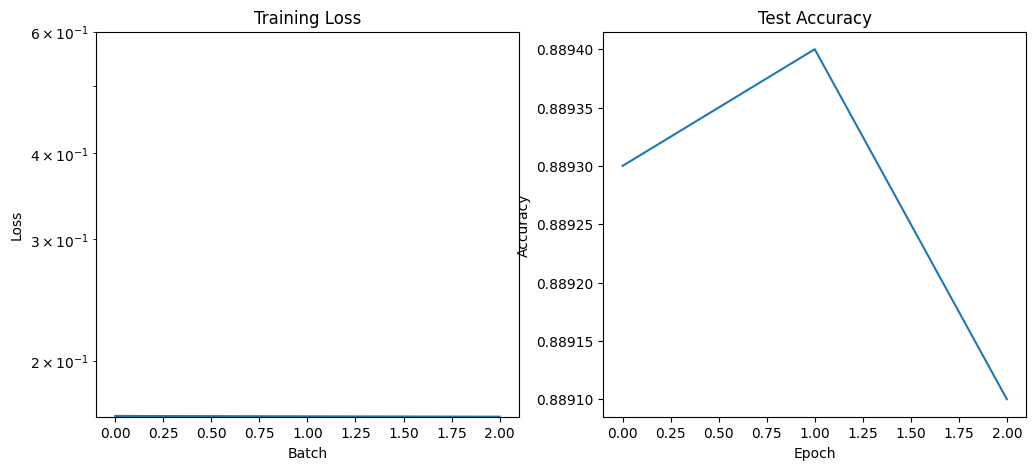

Epoch 4/400:   0%|                                                            | 0/1 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [47]:
# model_MLP = MLP()

# nn.init.normal_(model_MLP.net[0].weight, mean=0.0, std=0.01)
# nn.init.zeros_(model_MLP.net[0].bias)
# nn.init.normal_(model_MLP.net[2].weight, mean=0.0, std=0.05)
# nn.init.zeros_(model_MLP.net[2].bias)

trainer(training_data, model_MLP, nn.CrossEntropyLoss(), batch_size=60000, epoch=400, rate=1e-1)

In [17]:
success_rate_vector(model_MLP, test_data)

8893 out of 10000 correct


0.8893

In [10]:
trainer(training_data, model_MLP, nn.CrossEntropyLoss(), batch_size=512, epoch=5)

Epoch 5/5: 100%|██████████████████████████████████████| 118/118 [00:06<00:00, 18.50it/s, loss=0.332]


In [11]:
success_rate_vector(model_MLP, test_data)

8563 out of 10000 correct


0.8563